In [7]:
# Setup and Imports
%load_ext autoreload
%autoreload 2

import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from uncertainties import ufloat
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Add the src directory to import snowpyt_mechparams
sys.path.append('../src')
from snowpilot_utils import convert_grain_form, parse_sample_pits
from snowpyt_mechparams import density, elastic_modulus, shear_modulus, poissons_ratio


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Parse all snowpit files from the data folder
all_pits = parse_sample_pits('data')


Successfully parsed 50278 files
Failed to parse 0 files


In [3]:
# Calculate densities for all layers using kim_geldsetzer method
layer_info = []

for pit in all_pits:
    for layer in pit.snow_profile.layers:
        layer_dict = {
            'pit_id': pit.core_info.pit_id,
            'hand_hardness': layer.hardness,
            'depth_top': layer.depth_top[0] if layer.depth_top else None,  
            'thickness': layer.thickness[0] if layer.thickness else None,
        }

        # Convert grain form and calculate density
        grain_form = convert_grain_form(layer.grain_form_primary, 'kim_geldsetzer') if layer.grain_form_primary else None
        layer_dict['kim_geldsetzer_grain_form'] = grain_form
        
        # Calculate density if we have valid inputs
        if layer.hardness and grain_form:
            try:
                density_ufloat = density.calculate_density( 
                    method='kim_geldsetzer',
                    hand_hardness=layer.hardness,
                    grain_form=grain_form
                )
                layer_dict['density_kim_geldsetzer'] = density_ufloat.nominal_value
                layer_dict['density_kim_geldsetzer_uncertainty'] = density_ufloat.std_dev
            except Exception:
                layer_dict['density_kim_geldsetzer'] = None
                layer_dict['density_kim_geldsetzer_uncertainty'] = None
        else:
            layer_dict['density_kim_geldsetzer'] = None
            layer_dict['density_kim_geldsetzer_uncertainty'] = None

        layer_info.append(layer_dict)

# Create dataframe
layer_df = pd.DataFrame(layer_info)


In [ ]:
# Calculate elastic modulus and shear modulus using wautier method

# Function to calculate elastic modulus and shear modulus for a single row
def calculate_modulii_row(row):
    result = {'e_mod_wautier': None, 's_mod_wautier': None}
    
    # Skip if no grain form or density data
    if pd.isna(row['kim_geldsetzer_grain_form']) or pd.isna(row['density_kim_geldsetzer']):
        return pd.Series(result)
    
    try:
        # Create density ufloat once
        density_ufloat = ufloat(row['density_kim_geldsetzer'], row['density_kim_geldsetzer_uncertainty'])
        grain_form = row['kim_geldsetzer_grain_form']
        
        # Calculate elastic modulus using wautier method
        try:
            e_mod = elastic_modulus.calculate_elastic_modulus(
                method='wautier',
                density=density_ufloat,
                grain_form=grain_form
            )
            result['e_mod_wautier'] = e_mod.nominal_value
        except Exception:
            pass
        
        # Calculate shear modulus using wautier method
        try:
            s_mod = shear_modulus.calculate_shear_modulus(
                method='wautier',
                density=density_ufloat,
                grain_form=grain_form
            )
            result['s_mod_wautier'] = s_mod.nominal_value
        except Exception:
            pass
    except Exception:
        pass
    
    return pd.Series(result)

# Apply the function to all rows at once
layer_df[['e_mod_wautier', 's_mod_wautier']] = layer_df.apply(calculate_modulii_row, axis=1)


/Users/marykateconnelly/Desktop/F25/SnowPyt-MechParams/venv/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [ ]:
# Function to calculate poissons ratio for a single row using multiple methods
def calculate_poissons_ratio_row(row):
    """Calculate poissons ratio for a single row using multiple methods."""
    result = {
        'nu_kochle': np.nan,
        'nu_srivastava': np.nan,
        'nu_from_modulii': np.nan
    }
    
    # Skip if no grain form or density data
    if pd.isna(row['kim_geldsetzer_grain_form']) or pd.isna(row['density_kim_geldsetzer']):
        return pd.Series(result)
    
    try:
        # Create density ufloat once
        density_ufloat = ufloat(row['density_kim_geldsetzer'], row['density_kim_geldsetzer_uncertainty'])
        grain_form = row['kim_geldsetzer_grain_form']
        
        # Calculate Poisson's ratio using Kochle method
        try:
            nu_kochle = poissons_ratio.calculate_poissons_ratio(
                method='kochle',
                grain_form=grain_form
            )
            result['nu_kochle'] = nu_kochle.nominal_value
        except Exception:
            pass
        
        # Calculate Poisson's ratio using Srivastava method
        try:
            nu_srivastava = poissons_ratio.calculate_poissons_ratio(
                method='srivastava',
                density=density_ufloat,
                grain_form=grain_form
            )
            result['nu_srivastava'] = nu_srivastava.nominal_value
        except Exception:
            pass
        
        # Calculate Poisson's ratio from modulii (using wautier E and G)
        # Only calculate if both e_mod_wautier and s_mod_wautier are available
        if not pd.isna(row['e_mod_wautier']) and not pd.isna(row['s_mod_wautier']):
            try:
                # Create ufloats for the moduli (assuming no uncertainty stored)
                e_mod_ufloat = ufloat(row['e_mod_wautier'], 0)
                s_mod_ufloat = ufloat(row['s_mod_wautier'], 0)
                
                nu_from_modulii = poissons_ratio.calculate_poissons_ratio(
                    method='from_modulii',
                    elastic_modulus=e_mod_ufloat,
                    shear_modulus=s_mod_ufloat
                )
                result['nu_from_modulii'] = nu_from_modulii.nominal_value
            except Exception:
                pass
        
    except Exception:
        pass
    
    return pd.Series(result)

# Apply the function to all rows at once
layer_df[['nu_kochle', 'nu_srivastava', 'nu_from_modulii']] = layer_df.apply(calculate_poissons_ratio_row, axis=1)


/Users/marykateconnelly/Desktop/F25/SnowPyt-MechParams/venv/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


/var/folders/ft/ml81yv0j2v39f8t4xlgfn9h40000gn/T/ipykernel_15559/1768408524.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax4.boxplot(data_by_grain, labels=grain_types, patch_artist=True)
/var/folders/ft/ml81yv0j2v39f8t4xlgfn9h40000gn/T/ipykernel_15559/1768408524.py:71: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax5.boxplot(data_by_grain_sriv, labels=grain_types_sriv, patch_artist=True)
/var/folders/ft/ml81yv0j2v39f8t4xlgfn9h40000gn/T/ipykernel_15559/1768408524.py:84: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp3 = ax6.boxplot(data_by_grain_mod, labels=grain_types_mod, patch_artist=True)


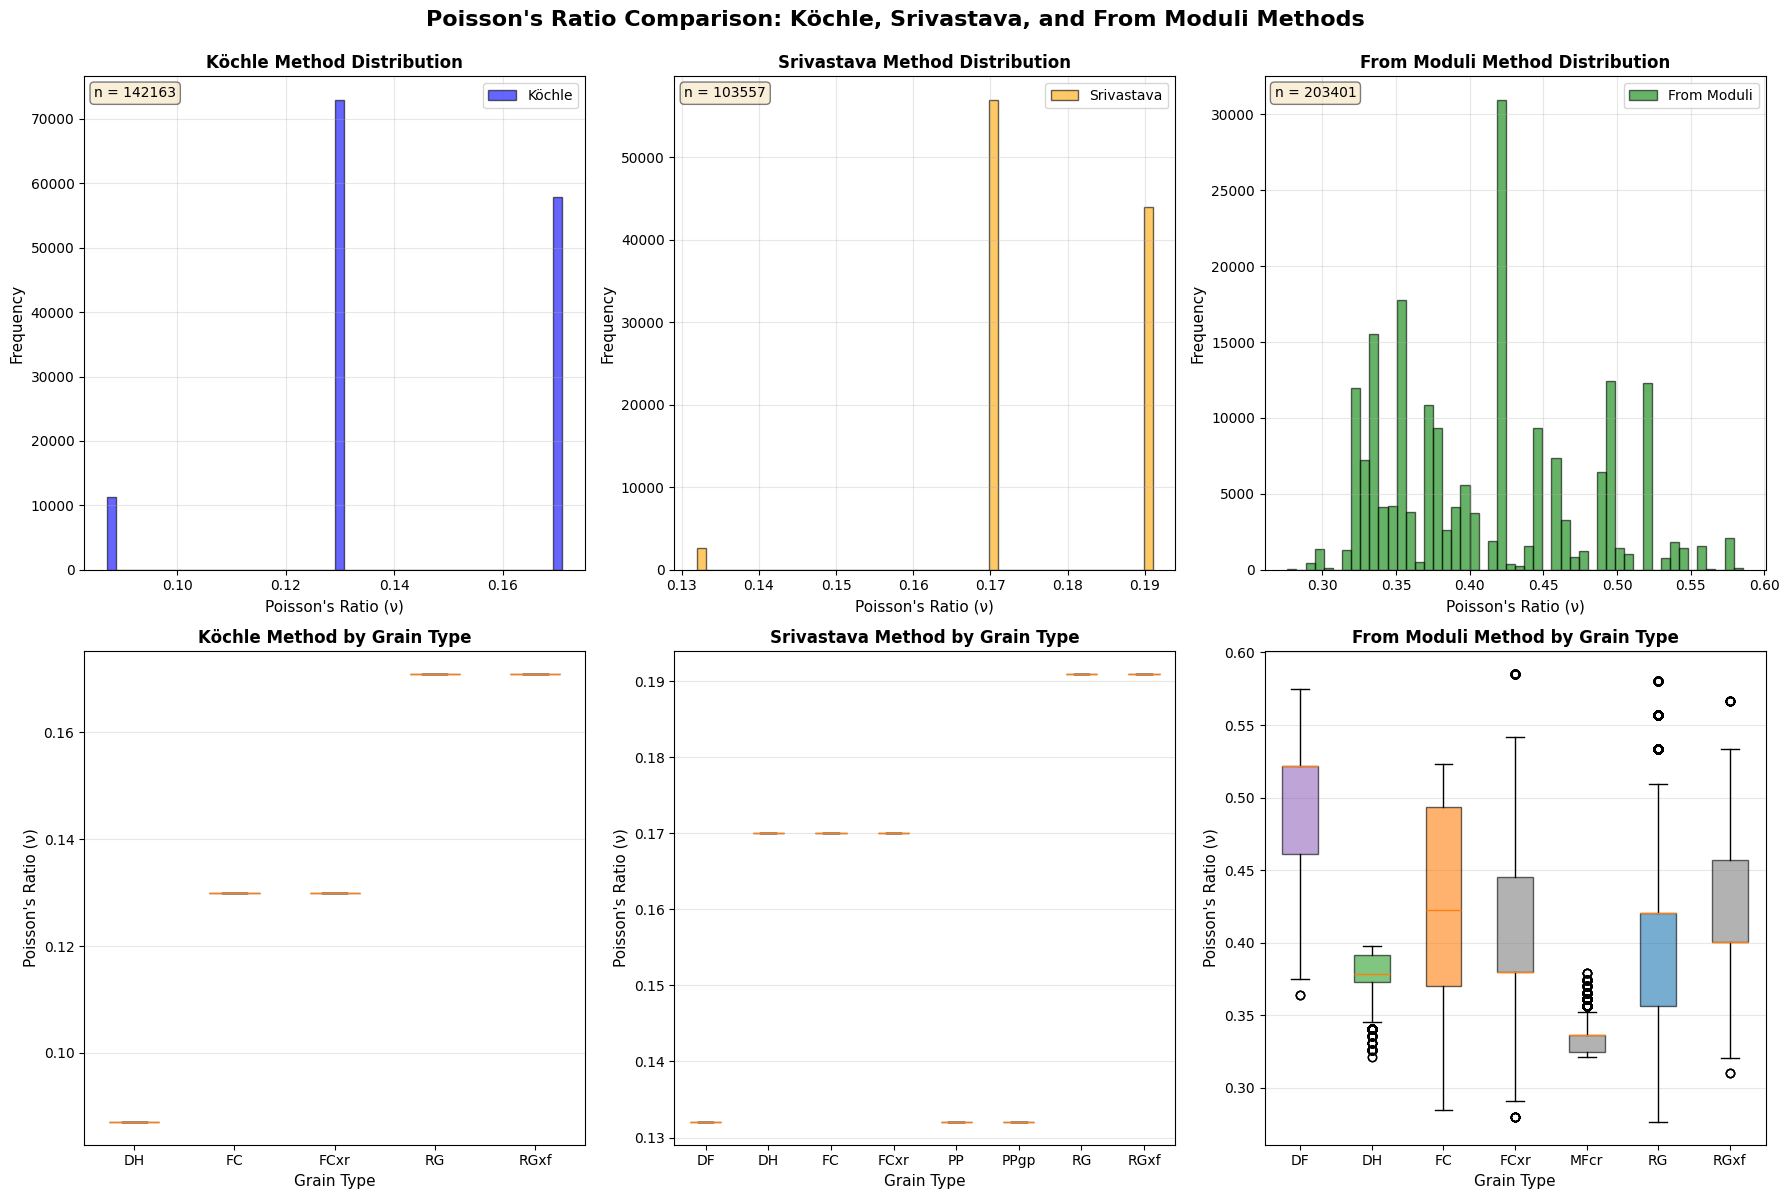


POISSON'S RATIO COMPARISON SUMMARY STATISTICS

KÖCHLE METHOD:
  Count: 142163
  Mean: 0.1433
  Std Dev: 0.0256
  Min: 0.0870
  Max: 0.1710
  Median: 0.1300

SRIVASTAVA METHOD:
  Count: 103557
  Mean: 0.1780
  Std Dev: 0.0127
  Min: 0.1320
  Max: 0.1910
  Median: 0.1700

FROM MODULI METHOD:
  Count: 203401
  Mean: 0.4098
  Std Dev: 0.0669
  Min: 0.2762
  Max: 0.5853
  Median: 0.4007


POISSON'S RATIO BY GRAIN TYPE:
--------------------------------------------------------------------------------

KÖCHLE:
  DH: mean=0.0870, std=0.0000, n=11325
  FC: mean=0.1300, std=0.0000, n=47995
  FCxr: mean=0.1300, std=0.0000, n=24979
  RG: mean=0.1710, std=0.0000, n=52387
  RGxf: mean=0.1710, std=0.0000, n=5477

SRIVASTAVA:
  DF: mean=0.1320, std=0.0000, n=1796
  DH: mean=0.1700, std=0.0000, n=11325
  FC: mean=0.1700, std=0.0000, n=29876
  FCxr: mean=0.1700, std=0.0000, n=15747
  PP: mean=0.1320, std=0.0000, n=350
  PPgp: mean=0.1320, std=0.0000, n=461
  RG: mean=0.1910, std=0.0000, n=40684
  RGxf: 

In [9]:
# Visualize poissons ratio comparison

# Create a comprehensive figure with multiple subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("Poisson's Ratio Comparison: Köchle, Srivastava, and From Moduli Methods", 
             fontsize=16, fontweight='bold', y=0.995)

# Filter out NaN values for each method
df_kochle = layer_df[~layer_df['nu_kochle'].isna()]
df_srivastava = layer_df[~layer_df['nu_srivastava'].isna()]
df_from_modulii = layer_df[~layer_df['nu_from_modulii'].isna()]

# Color scheme for grain types
grain_colors = {
    'RG': '#1f77b4',  # blue
    'FC': '#ff7f0e',  # orange
    'DH': '#2ca02c',  # green
    'PP': '#d62728',  # red
    'DF': '#9467bd',  # purple
}

# 1. Histograms of each method
ax1 = axes[0, 0]
ax1.hist(df_kochle['nu_kochle'], bins=50, alpha=0.6, label='Köchle', color='blue', edgecolor='black')
ax1.set_xlabel('Poisson\'s Ratio (ν)', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Köchle Method Distribution', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.text(0.02, 0.98, f'n = {len(df_kochle)}', transform=ax1.transAxes, 
         verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax2 = axes[0, 1]
ax2.hist(df_srivastava['nu_srivastava'], bins=50, alpha=0.6, label='Srivastava', color='orange', edgecolor='black')
ax2.set_xlabel('Poisson\'s Ratio (ν)', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Srivastava Method Distribution', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.text(0.02, 0.98, f'n = {len(df_srivastava)}', transform=ax2.transAxes, 
         verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax3 = axes[0, 2]
ax3.hist(df_from_modulii['nu_from_modulii'], bins=50, alpha=0.6, label='From Moduli', color='green', edgecolor='black')
ax3.set_xlabel('Poisson\'s Ratio (ν)', fontsize=11)
ax3.set_ylabel('Frequency', fontsize=11)
ax3.set_title('From Moduli Method Distribution', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.text(0.02, 0.98, f'n = {len(df_from_modulii)}', transform=ax3.transAxes, 
         verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Box plots by grain type for each method
ax4 = axes[1, 0]
grain_types = sorted(df_kochle['kim_geldsetzer_grain_form'].unique())
data_by_grain = [df_kochle[df_kochle['kim_geldsetzer_grain_form'] == gt]['nu_kochle'].dropna() 
                 for gt in grain_types]
bp1 = ax4.boxplot(data_by_grain, labels=grain_types, patch_artist=True)
for patch, gt in zip(bp1['boxes'], grain_types):
    patch.set_facecolor(grain_colors.get(gt, 'gray'))
    patch.set_alpha(0.6)
ax4.set_xlabel('Grain Type', fontsize=11)
ax4.set_ylabel('Poisson\'s Ratio (ν)', fontsize=11)
ax4.set_title('Köchle Method by Grain Type', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

ax5 = axes[1, 1]
grain_types_sriv = sorted(df_srivastava['kim_geldsetzer_grain_form'].unique())
data_by_grain_sriv = [df_srivastava[df_srivastava['kim_geldsetzer_grain_form'] == gt]['nu_srivastava'].dropna() 
                      for gt in grain_types_sriv]
bp2 = ax5.boxplot(data_by_grain_sriv, labels=grain_types_sriv, patch_artist=True)
for patch, gt in zip(bp2['boxes'], grain_types_sriv):
    patch.set_facecolor(grain_colors.get(gt, 'gray'))
    patch.set_alpha(0.6)
ax5.set_xlabel('Grain Type', fontsize=11)
ax5.set_ylabel('Poisson\'s Ratio (ν)', fontsize=11)
ax5.set_title('Srivastava Method by Grain Type', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

ax6 = axes[1, 2]
grain_types_mod = sorted(df_from_modulii['kim_geldsetzer_grain_form'].unique())
data_by_grain_mod = [df_from_modulii[df_from_modulii['kim_geldsetzer_grain_form'] == gt]['nu_from_modulii'].dropna() 
                     for gt in grain_types_mod]
bp3 = ax6.boxplot(data_by_grain_mod, labels=grain_types_mod, patch_artist=True)
for patch, gt in zip(bp3['boxes'], grain_types_mod):
    patch.set_facecolor(grain_colors.get(gt, 'gray'))
    patch.set_alpha(0.6)
ax6.set_xlabel('Grain Type', fontsize=11)
ax6.set_ylabel('Poisson\'s Ratio (ν)', fontsize=11)
ax6.set_title('From Moduli Method by Grain Type', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("POISSON'S RATIO COMPARISON SUMMARY STATISTICS")
print("="*80)

print("\nKÖCHLE METHOD:")
print(f"  Count: {len(df_kochle)}")
print(f"  Mean: {df_kochle['nu_kochle'].mean():.4f}")
print(f"  Std Dev: {df_kochle['nu_kochle'].std():.4f}")
print(f"  Min: {df_kochle['nu_kochle'].min():.4f}")
print(f"  Max: {df_kochle['nu_kochle'].max():.4f}")
print(f"  Median: {df_kochle['nu_kochle'].median():.4f}")

print("\nSRIVASTAVA METHOD:")
print(f"  Count: {len(df_srivastava)}")
print(f"  Mean: {df_srivastava['nu_srivastava'].mean():.4f}")
print(f"  Std Dev: {df_srivastava['nu_srivastava'].std():.4f}")
print(f"  Min: {df_srivastava['nu_srivastava'].min():.4f}")
print(f"  Max: {df_srivastava['nu_srivastava'].max():.4f}")
print(f"  Median: {df_srivastava['nu_srivastava'].median():.4f}")

print("\nFROM MODULI METHOD:")
print(f"  Count: {len(df_from_modulii)}")
print(f"  Mean: {df_from_modulii['nu_from_modulii'].mean():.4f}")
print(f"  Std Dev: {df_from_modulii['nu_from_modulii'].std():.4f}")
print(f"  Min: {df_from_modulii['nu_from_modulii'].min():.4f}")
print(f"  Max: {df_from_modulii['nu_from_modulii'].max():.4f}")
print(f"  Median: {df_from_modulii['nu_from_modulii'].median():.4f}")

print("\n" + "="*80)

# Print statistics by grain type
print("\nPOISSON'S RATIO BY GRAIN TYPE:")
print("-" * 80)
for method_name, col_name in [('Köchle', 'nu_kochle'), ('Srivastava', 'nu_srivastava'), ('From Moduli', 'nu_from_modulii')]:
    print(f"\n{method_name.upper()}:")
    df_method = layer_df[~layer_df[col_name].isna()]
    for gt in sorted(df_method['kim_geldsetzer_grain_form'].unique()):
        data = df_method[df_method['kim_geldsetzer_grain_form'] == gt][col_name]
        print(f"  {gt}: mean={data.mean():.4f}, std={data.std():.4f}, n={len(data)}")

print("\n" + "="*80)
